## Import the Data

This notebook will explore the usage of different toolkit functions to filter data and compute power curves from a single wind turbine. We start the notebook by importing a project file (turbine_project.py, in this case), instantiating a project, and calling its prepare method. This process provides us with a PlantData object (turbine, in this case) which can be used to query data.

In [1]:
from turbine_project import TurbineExampleProject

turbine = TurbineExampleProject()
turbine.prepare()

display(turbine.scada.head())

INFO:operational_analysis.types.timeseries_table:Loading name:scada_10min_4cols


,time,power_kw,winddirection_deg,windspeed_ms,id,energy_kwh
time,,,,,,
2010-02-17 19:30:00,2010-02-17 19:30:00,-2.07,0.0,0.63,T0,-0.345000
2010-02-17 19:40:00,2010-02-17 19:40:00,-2.24,0.0,1.81,T0,-0.373333
2010-02-17 19:50:00,2010-02-17 19:50:00,-3.10,0.0,2.13,T0,-0.516667
2010-02-17 20:00:00,2010-02-17 20:00:00,-1.91,0.0,1.33,T0,-0.318333
2010-02-17 20:10:00,2010-02-17 20:10:00,-1.89,0.0,0.63,T0,-0.315000


PlantData objects contain references to several TimeseriesTable objects. The only one which is useful for this demo is "scada." The "df" member of the scada TimeseriesTable exposes a Pandas dataframe which contains cleaned SCADA data. Let's use turbine.scada to define python variables windspeed, power_kw, and df for convenience in later examples.

In [2]:
windspeed = turbine.scada.df["windspeed_ms"]
power_kw = turbine.scada.df["power_kw"]
df = turbine.scada.df

## Filter the Data

The filtering toolkit implements commonly used filters and operated by returning a boolean series called "flag" which can be used to index the original dataframe. We start by importing the filtering toolkit:

In [3]:
from operational_analysis.toolkits import filters

First let's define a plotting function for the turbine power curve which we can use to examine the effect of different filtering functions on the data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

Now first let's take a look at the unprocessed data:

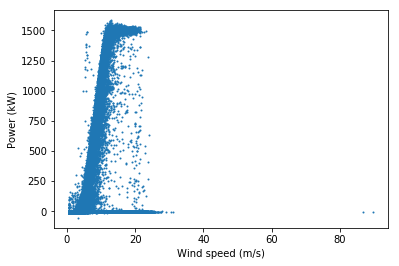

In [6]:
plot_flagged_pc(windspeed, power_kw, np.repeat('True', df.shape[0]), 1)

### Range Filter

We immediately see two high wind speed outliers likely due to sensor malfunction. We can flag and filter these outliers from the dataset using the 'range_flag' function:

In [7]:
# Show outliers
out_of_range = filters.range_flag(windspeed, below=0.01, above=70)
windspeed[out_of_range].head()

time
2017-02-03 20:00:00    89.79
2017-02-03 20:10:00    86.67
Name: windspeed_ms, dtype: float64

Let's remove the outliers and plot the result:

In [8]:
# Remove outliers
windspeed = windspeed[~out_of_range]
power_kw = power_kw[~out_of_range]

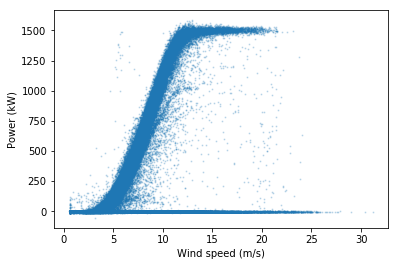

In [9]:
# Show updated power curve
plot_flagged_pc(windspeed, power_kw, np.repeat('True', df.shape[0]), 0.2)

### Window Range Filter

We may want to remove turbine downtime events, which we can identify as near zero power at high wind speeds. We can do this using the 'window_range function' and removing data greater than 6 m/s but with power less than 20 kW:

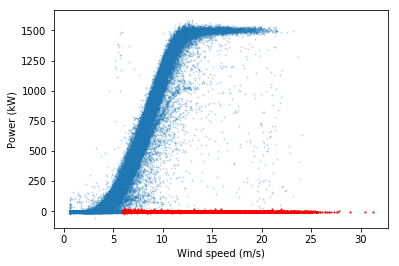

In [10]:
out_of_window = filters.window_range_flag(windspeed, 6., 40, power_kw, 20., 2000.)
plot_flagged_pc(windspeed, power_kw, out_of_window, 0.2)

Again, let's remove these flagged data from consideration:

In [11]:
windspeed = windspeed[~out_of_window]
power_kw = power_kw[~out_of_window]

### Bin Filter

We may be interested in fitting a power curve to data representing 'normal' turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the 'bin_filter' function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let's bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don't want to flag all the data at peak power and high wind speed. Let's use a scalar threshold of 1.5 m/s from the median for each bin. Let's also consider data on both sides of the curve by setting the 'direction' parameter to 'all'

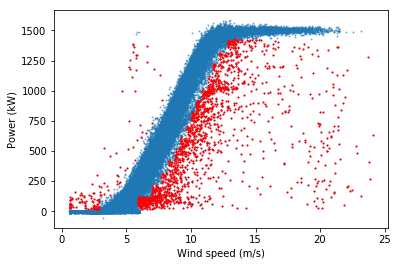

In [12]:
max_bin = 0.90*power_kw.max()
bin_outliers = filters.bin_filter(power_kw, windspeed, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
plot_flagged_pc(windspeed, power_kw, bin_outliers, 0.5)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent 'normal' operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren't flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our 'clean' power curve 

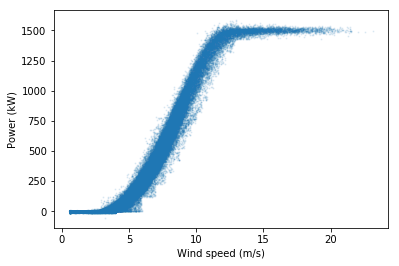

In [13]:
out_of_window = filters.window_range_flag(windspeed, 4., 8., power_kw, 0., 1250.)
windspeed = windspeed[(~out_of_window) & (~bin_outliers)]
power_kw = power_kw[(~out_of_window) & (~bin_outliers)]
plot_flagged_pc(windspeed, power_kw, np.repeat('True', len(windspeed)), 0.1)

The bin filter gives a bit of a 'choppy' look to the power curve at lower wind speeds, which we could clean up by using a smaller bin size.

### Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let's look for 3 or more repeating wind speed measurements:

In [14]:
frozen = filters.unresponsive_flag(windspeed, 3)
windspeed[frozen].head()

time
2010-02-18 02:10:00    0.63
2010-02-18 02:20:00    0.63
2010-02-18 02:30:00    0.63
2010-02-18 02:40:00    0.63
2010-02-18 02:50:00    0.63
Name: windspeed_ms, dtype: float64

We actually found a lot, so let's remove these data as well before moving on to power curve fitting.

In [15]:
windspeed = windspeed[~frozen]
power_kw = power_kw[~frozen]

## Fit the Power Curves

Now that our data has been reasonably processed, we can fit a power curve model to the data. Here we illustrate three types of power curves: the standard IEC binned power curve model, a spline fit, and a Logistic 5 parameter model (L5P):

In [16]:
from operational_analysis.toolkits import power_curve

In [17]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed, power_kw)
l5p_curve = power_curve.logistic_5_parametric(windspeed, power_kw)
spline_curve = power_curve.gam(windspeed, power_kw, n_splines = 20)

C:\ProgramData\Anaconda3\lib\site-packages\operational_analysis\toolkits\power_curve\parametric_forms.py:35: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / (1 + (x / c) ** b) ** g


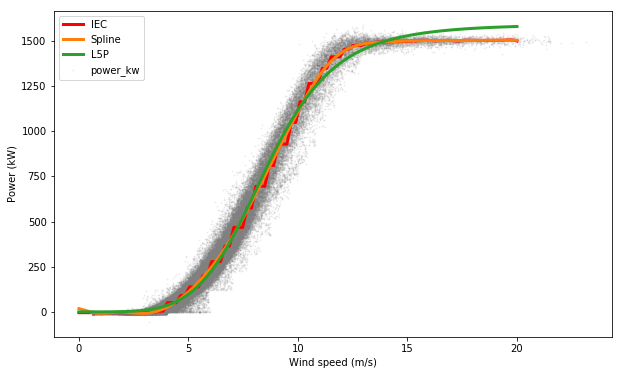

In [18]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed, power_kw, alpha=0.1, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

The above plot shows that both the IEC and spline method accurately capture the power curve (although the IEC method results in a 'choppy' fit), while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production.

### Relative Speed of Power Curve Fitting

We also note the speed of the computations. The IEC method is by far the fastest, followed by the spline fit, and then the L5P model.

In [19]:
import time

In [20]:
start = time.time()
power_curve.IEC(windspeed, power_kw)
end = time.time()
print ('IEC: ' + str(np.round(end - start, 3)) + ' seconds')

IEC: 0.212 seconds


In [21]:
start = time.time()
power_curve.gam(windspeed, power_kw, n_splines=20)
end = time.time()
print ('Spline: ' + str(np.round(end - start, 3)) + ' seconds')

Spline: 3.128 seconds


In [22]:
start = time.time()
power_curve.logistic_5_parametric(windspeed, power_kw)
end = time.time()
print ('L5P: ' + str(np.round(end - start, 3)) + ' seconds')

L5P: 58.219 seconds


In [23]:
l5p_curve(x)

C:\ProgramData\Anaconda3\lib\site-packages\operational_analysis\toolkits\power_curve\parametric_forms.py:35: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / (1 + (x / c) ** b) ** g


array([1.00000000e-03, 1.03123323e-03, 1.79416710e-03, 6.27177307e-03,
       2.11932677e-02, 5.82281666e-02, 1.35044478e-01, 2.76278186e-01,
       5.14436618e-01, 8.90747477e-01, 1.45595854e+00, 2.27108749e+00,
       3.40811574e+00, 4.95061385e+00, 6.99427883e+00, 9.64735497e+00,
       1.30308995e+01, 1.72788433e+01, 2.25377832e+01, 2.89664304e+01,
       3.67346248e+01, 4.60218151e+01, 5.70148977e+01, 6.99053032e+01,
       8.48852355e+01, 1.02142985e+02, 1.21857287e+02, 1.44190748e+02,
       1.69282468e+02, 1.97240076e+02, 2.28131522e+02, 2.61977111e+02,
       2.98742361e+02, 3.38332338e+02, 3.80588161e+02, 4.25286278e+02,
       4.72140968e+02, 5.20810271e+02, 5.70905241e+02, 6.22002060e+02,
       6.73656262e+02, 7.25418052e+02, 7.76847609e+02, 8.27529282e+02,
       8.77083739e+02, 9.25177393e+02, 9.71528745e+02, 1.01591159e+03,
       1.05815533e+03, 1.09814277e+03, 1.13580610e+03, 1.17112139e+03,
       1.20410245e+03, 1.23479439e+03, 1.26326720e+03, 1.28960990e+03,
      

### Use ENGIE’s open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine, as well as the start and end date, can be changed.

In [24]:
from turbine_project import TurbineEngieOpenData

engie = TurbineEngieOpenData(name = 'R80711',start_date = "01.01.2017 00:00",end_date = "03.01.2017 00:00")
engie.prepare()
engie.scada.df.sort_index(inplace=True)

display(engie.scada.head())

,ba_avg,ba_max,ba_min,ba_std,cm_avg,cm_max,cm_min,cm_std,cosphi_avg,cosphi_max,...,ya_min,ya_std,yt_avg,yt_max,yt_min,yt_std,time,power_kw,winddirection_deg,windspeed_ms
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-0.99,-0.99,-0.99,0.0,1460.6700,1763.3600,1142.8101,197.600010,0.99,0.98,...,209.63000,0.00,16.680000,17.100000,16.299999,0.24,2017-01-01 00:00:00,143.06000,195.17000,5.36
2017-01-01 00:10:00,-0.99,-0.99,-0.99,0.0,2080.8201,2553.8999,1750.5200,207.750000,1.00,1.00,...,187.67999,10.71,17.570000,18.200001,17.100000,0.36,2017-01-01 00:10:00,262.19000,180.41000,5.91
2017-01-01 00:20:00,-0.99,-0.99,-0.99,0.0,2653.1201,2937.9700,2265.0100,167.570010,1.00,1.00,...,187.67999,8.07,18.719999,18.900000,18.200001,0.22,2017-01-01 00:20:00,393.03000,208.12000,6.19
2017-01-01 00:30:00,-0.99,-0.99,-0.99,0.0,2728.2400,2976.9900,2576.7800,79.440002,1.00,1.00,...,204.14999,0.00,19.240000,19.700001,18.900000,0.24,2017-01-01 00:30:00,410.57001,198.47000,5.94
2017-01-01 00:40:00,-0.99,-0.99,-0.99,0.0,2956.0801,3150.6399,2778.5601,103.140000,1.00,1.00,...,204.14999,0.00,20.370001,20.900000,19.700001,0.30,2017-01-01 00:40:00,468.63000,197.74001,6.35


The data set includes many more sensor values in addition to time, power_kw, winddirection_deg, and windspeed_ms. The latter are renamed to match OpenOA's naming conventions. Let's plot the data.

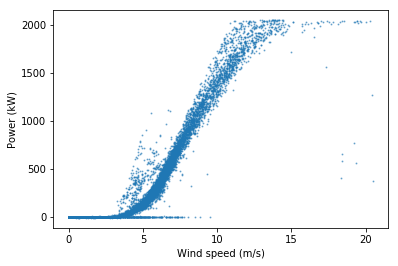

In [25]:
plot_flagged_pc(engie.scada.df["windspeed_ms"], engie.scada.df["power_kw"], np.repeat('True', df.shape[0]), 0.5)

In the next steps, we apply all filters following the previous example. In addition, we make sure to delete all Null values beforehand.

In [26]:
# Basic filtering for NaNs
df = engie.scada.df
df = df[df["windspeed_ms"].notnull()]
df = df[df["power_kw"].notnull()]
# Assign data 
windspeed = df["windspeed_ms"]
power_kw =  df["power_kw"]
# Remove outliers
out_of_range = filters.range_flag(windspeed, below=0.01, above=70)
windspeed = windspeed[~out_of_range]
power_kw = power_kw[~out_of_range]
# Window Range Filter
out_of_window = filters.window_range_flag(windspeed, 6., 40, power_kw, 20., 2500.)
windspeed = windspeed[~out_of_window]
power_kw = power_kw[~out_of_window]
# Bin Filter
max_bin = 0.90*power_kw.max()
bin_outliers = filters.bin_filter(power_kw, windspeed, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
windspeed = windspeed[~bin_outliers]
power_kw = power_kw[~bin_outliers]
# Unresponsive Filter
frozen = filters.unresponsive_flag(windspeed, 3)
windspeed = windspeed[~frozen]
power_kw = power_kw[~frozen]

The result is a cleaner data set.

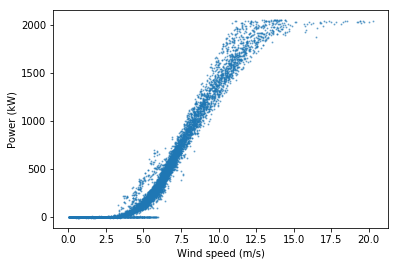

In [27]:
plot_flagged_pc(windspeed, power_kw, np.repeat('True', len(windspeed)), 0.5)

In [28]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed, power_kw)
l5p_curve = power_curve.logistic_5_parametric(windspeed, power_kw)
spline_curve = power_curve.gam(windspeed, power_kw, n_splines = 20)

C:\ProgramData\Anaconda3\lib\site-packages\operational_analysis\toolkits\power_curve\parametric_forms.py:35: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / (1 + (x / c) ** b) ** g


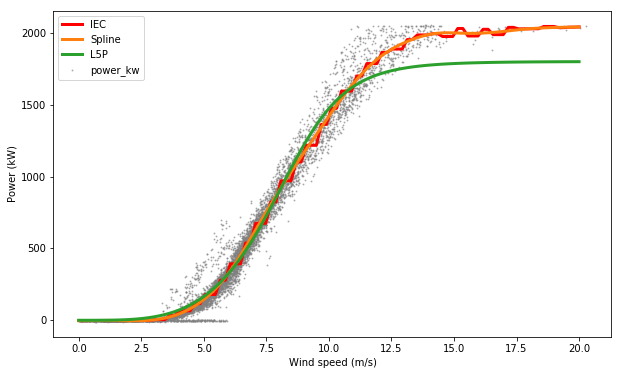

In [29]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed, power_kw, alpha=0.5, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()